In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [ ]:
#nvidia prices (1 year) into Data Frame
nvidia = yf.Tickers('NVDA')
nhist = nvidia.history(period='3y')

#Take only date, close, vol columns
nhist = nhist.drop(columns=['Stock Splits', 'Dividends', 'High', 'Low', 'Open'])

dev = np.std(nhist)

#find correlation between volumne and closing price for Nvidia
corr = nhist[['Close', 'Volume']].corr()
corr = corr.iloc[1, 0]
corr

[*********************100%***********************]  1 of 1 completed
C:\Users\stanx\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:4109: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


np.float64(-0.5543313548373848)

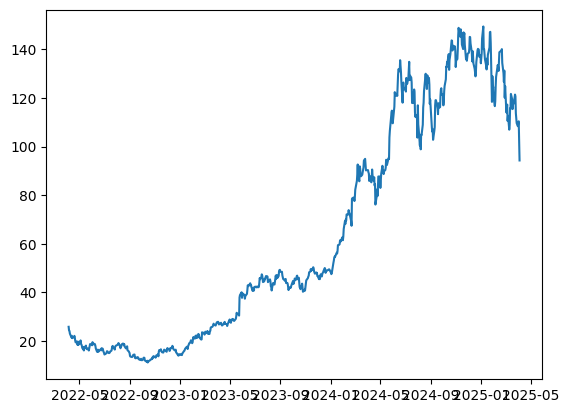

In [86]:
#nvidia price over time
plt.plot(nhist['Close'])

    


In [164]:
nPrice3mo = nvidia.history(period='3mo', interval='1mo')
nvda3mo = yf.Ticker('NVDA').get_recommendations()
nvda3mo = nvda3mo.drop(3)

mereg1 = nPrice3mo.reset_index()
mereg2 = nvda3mo.reset_index()

merged_nvda = pd.concat([mereg1, mereg2], axis=1)
merged_nvda = merged_nvda.drop(index={2})
merged_nvda

[*********************100%***********************]  1 of 1 completed


,"(Date, )","(Close, NVDA)","(Dividends, NVDA)","(High, NVDA)","(Low, NVDA)","(Open, NVDA)","(Stock Splits, NVDA)","(Volume, NVDA)",index,period,strongBuy,buy,hold,sell,strongSell
0,2025-02-01,124.908508,0.00,143.426809,112.999608,114.739446,0.0,4755230400,0,0m,11,45,6,0,0
1,2025-03-01,108.370033,0.01,123.688625,103.640472,123.498647,0.0,6177950300,1,-1m,11,46,5,0,0


In [137]:
nvda3mo

,period,strongBuy,buy,hold,sell,strongSell
0,0m,11,45,6,0,0
1,-1m,11,46,5,0,0
2,-2m,11,46,5,0,0
3,-3m,12,47,4,0,0


In [106]:
crypto = yf.Market('CRYPTOCURRENCIES')
crypto.status

{'id': 'us',
 'name': 'U.S. markets',
 'status': 'closed',
 'yfit_market_id': 'us_market',
 'close': datetime.datetime(2025, 4, 4, 20, 0, tzinfo=datetime.timezone.utc),
 'message': 'U.S. markets closed',
 'open': datetime.datetime(2025, 4, 4, 13, 30, tzinfo=datetime.timezone.utc),
 'yfit_market_status': 'YFT_MARKET_CLOSED',
 'timezone': {'dst': 'true',
  'gmtoffset': '-14400',
  'short': 'EDT',
  '$text': 'America/New_York'},
 'tz': datetime.timezone(datetime.timedelta(days=-1, seconds=34560), 'EDT')}

In [84]:
gold = yf.Sector('gold')
gold.top_mutual_funds

Failed to get sector data for 'gold' reason: 404 Client Error: Not Found for url: https://query1.finance.yahoo.com/v1/finance/sectors/gold?formatted=true&withReturns=true&lang=en-US&region=US&crumb=MAdTesuvXuM
